In [1]:
import logging
import warnings
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import SpectralToolbox.Spectral1D as S1D
import TransportMaps as TM
import TransportMaps.Functionals as FUNC
import TransportMaps.Maps as MAPS
%matplotlib inline
warnings.simplefilter("ignore")
TM.setLogLevel(logging.INFO)

/home/dabi/.emacs.d/.python-environments/tm3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/dabi/.emacs.d/.python-environments/tm3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Available approximations

Let us consider the random variable $X$ distributed accordingly to the Gumbel distribution, with density 

$$\pi(x) = \frac{1}{\beta} \exp\left( -z - \exp(-z)\right) \;,$$

where $z=\frac{x-\mu}{\beta}$. Given the standard normal reference density $\rho$, we are looking for the map $T:\mathbb{R}\rightarrow \mathbb{R}$ such that

$$ \pi \approx T_\sharp \rho := \rho \circ T_\sharp \left\vert \nabla_x T \right\vert \;. $$

We measure the quality of such approximation using the Kullback-Leibler divergence, and thus we try to solve the following minimization problem

$$
\hat{T} = \arg\min_{T \in \mathcal{T}_\triangle} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert \nu_\pi \right) \;,
$$

over a set $\mathcal{T}_\triangle$ of triangular and monotonic transport maps. Elements of this set are parametrized and denoted by $T({\bf a},\cdot)$. 

First of all we need to define the distribution $\nu_\pi$, its density and a couple of its derivaties. This is done by the extension of the class [Distribution](api-TransportMaps-Distributions.html#TransportMaps.Distributions.Distribution).

In [2]:
import TransportMaps.Distributions as DIST

class GumbelDistribution(DIST.Distribution):
    def __init__(self, mu, beta):
        super(GumbelDistribution,self).__init__(1)
        self.mu = mu
        self.beta = beta
        self.dist = stats.gumbel_r(loc=mu, scale=beta)
    def pdf(self, x, params=None, *args, **kwargs):
        return self.dist.pdf(x).flatten()
    def log_pdf(self, x, params=None, *args, **kwargs):
        return self.dist.logpdf(x).flatten()
    def grad_x_log_pdf(self, x, params=None, *args, **kwargs):
        m = self.mu
        b = self.beta
        z = (x-m)/b
        return (np.exp(-z)-1.)/b
    def hess_x_log_pdf(self, x, params=None, *args, **kwargs):
        m = self.mu
        b = self.beta
        z = (x-m)/b
        return (-np.exp(-z)/b**2.)[:,:,np.newaxis]

mu = 3.
beta = 4.
pi = GumbelDistribution(mu,beta)

The code above defines the gradient and the Hessian of the log-pdf of the target. The availability of such information helps the optimizer finding the solution, but it is not necessary in general. In absence of such the Hessian and gradient information, one can use derivative free methods to solve the minimization problem. The TransportMaps framework can switch between the available methods depending on the problem formulation.

Let's see how the PDF of the defined Gumbel density looks like.

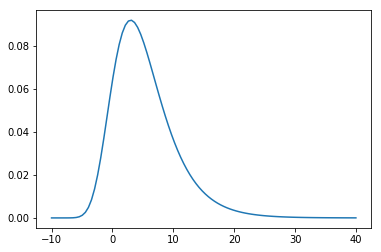

In [3]:
x = np.linspace(-10., 40., 100).reshape((100,1))
plt.figure()
plt.plot(x, pi.pdf(x));

For the sake of exposition we will provide here also a function that computes the **exact transport** $T^\star$ between a Standard Normal distribution $\nu_\rho$ and the target Gumbel distribution $\nu_\pi$

In [4]:
class GumbelTransportMap(object):
    def __init__(self, mu, beta):
        self.tar = stats.gumbel_r(loc=mu, scale=beta)
        self.ref = stats.norm(0.,1.)
    def evaluate(self, x, params=None):
        if isinstance(x,float):
            x = np.array([[x]])
        if x.ndim == 1:
            x = x[:,NAX]
        out = self.tar.ppf( self.ref.cdf(x) )
        return out
    def __call__(self, x):
        return self.evaluate(x)
Tstar = GumbelTransportMap(mu,beta)

Let's see how the exact transport map $T^\star$ looks like.

In [5]:
x_tm = np.linspace(-4,4,100).reshape((100,1))
def plot_mapping(tar_star, Tstar, tar=None, T=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_twx = ax.twinx()
    ax_twy = ax.twiny()
    ax.plot(x_tm, Tstar(x_tm), 'k-', label=r"$T^\star$") # Map
    n01, = ax_twx.plot(x_tm, stats.norm(0.,1.).pdf(x_tm), '-b') # N(0,1)
    g, = ax_twy.plot(tar_star.pdf(Tstar(x_tm)), Tstar(x_tm), '-r') # Gumbel
    if T is not None:
        ax.plot(x_tm, T(x_tm), 'k--', label=r"$\hat{T}$") # Map
    if tar is not None:
        ax_twy.plot(tar.pdf(Tstar(x_tm)), Tstar(x_tm), '--r') # Gumbel
    ax.set_ylabel(r"Map")
    ax_twx.set_ylabel('N(0,1)')
    ax_twx.yaxis.label.set_color(n01.get_color())
    ax_twy.set_xlabel('Gumbel')
    ax_twy.xaxis.label.set_color(g.get_color())
    ax.legend(loc = (0.1, 0.8))

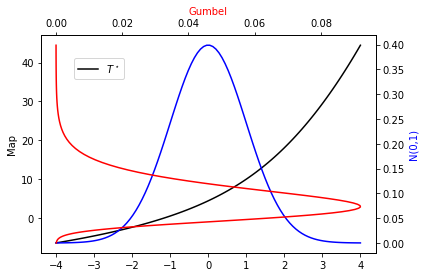

In [6]:
plot_mapping(pi, Tstar)

The triangular transport map $T$, in the $d$ dimensional case, takes the form:

$$ T({\bf a};{\bf x}) = \left[ \begin{array}{l} 
T_1({\bf a}_1;x_1) \\
T_2({\bf a}_2;x_1,x_2) \\
\vdots \\
T_d({\bf a}_d;x_1,\ldots,x_d)
\end{array}\right] \;. $$

In the case we are describing $d=1$, then $T({\bf a};{\bf x}) = T_1({\bf a}_1;x_1)$. 

We can chose between several types of parametrizations for $T_1,\ldots,T_d$: the linear span parametrization, the integrated exponential parametrization and the integrated squared parametrization. For **robustness** we recommend to use either the integrated exponential parametrization or the integrated squared parametrization

## Laplace approximation

The Laplace approximation consists in the fit of a Gaussian distribution $\tilde{\pi} \sim \mathcal{N}(\mu, \Sigma)$ to the target $\pi$, where we select the mean to be (one of) the mode(s) of the distribution

$$ \mu = \arg\max_{x} \log \pi(x) $$
    
and $\Sigma^{-1} = -\nabla^2 \log \pi(\mu)$. Then the linear transport map that pushes forward the reference distribution $\rho \sim \mathcal{N}({\bf 0},{\bf I})$ to the approximation $\tilde{\pi}$ of $\pi$ ($L_{\sharp} \rho = \tilde{\pi} \approx \pi$) is given by

$$ L({\bf x}) = \mu + \Sigma^{1/2} {\bf x} \;. $$

In [7]:
laplace_approx = TM.laplace_approximation(pi)
L = MAPS.LinearTransportMap.build_from_Gaussian(laplace_approx)
rho = DIST.StandardNormalDistribution(1)
approx_pi = DIST.PushForwardTransportMapDistribution(L, rho)

2018-12-08 18:52:58 INFO:TM.TransportMaps: Optimization terminated successfully
2018-12-08 18:52:58 INFO:TM.TransportMaps:   Function value:          2.386294
2018-12-08 18:52:58 INFO:TM.TransportMaps:   Norm of the Jacobian:    0.000000
2018-12-08 18:52:58 INFO:TM.TransportMaps:   Number of iterations:         5
2018-12-08 18:52:58 INFO:TM.TransportMaps:   N. function evaluations:      6
2018-12-08 18:52:58 INFO:TM.TransportMaps:   N. Jacobian evaluations:     10
2018-12-08 18:52:58 INFO:TM.TransportMaps:   N. Hessian evaluations:       5


Let's check the PDF approximation against the exact Gumbel distribution...

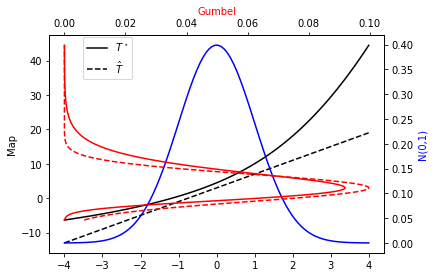

In [8]:
plot_mapping(pi, Tstar, approx_pi, L)

## Linear span parametrization

The linear span parametrization takes the simple form:

$$ T_k({\bf a},{\bf x}) = \Phi({\bf x}) {\bf a}\;, \qquad \text{for}\; {\bf x}=\{x_1,\ldots,x_k\} $$

A 3-rd order polynomial approximation can be built using the following code:

In [9]:
order = 3
Tk_list = []
active_vars = []
basis_list = [ S1D.HermiteProbabilistsPolynomial() ]
order_list = [ order ]
Tk = FUNC.MonotonicLinearSpanApproximation(
    basis_list, spantype='full', order_list=order_list)
Tk_list.append( Tk )
active_vars.append( [0] )
T = MAPS.MonotonicLinearSpanTriangularTransportMap(active_vars, Tk_list)

In the code above  

1. `basis_list` contains a list of one dimensional basis. Since $d=1$ the list contains only one element. 
2. `orders_list`, which define the polynomial order for in each dimension. 
3. `Tk` is the approximation $T_1$ defined above. 
4. The approximations $T_1,\ldots,T_d$ are collected into the list `Tk_list`. 
5. Element `i` of `approx_vars` states which are the active variables for approximation $T_i$. In this $T_1$ depends only on $x_1$ (in python counting, variable `0`). 
6. `T` represents the map $T$.

Alternatively, one can use the default constructor:

In [10]:
T = TM.Default_IsotropicMonotonicLinearSpanTriangularTransportMap(
    1, order, 'full')

We are then ready to set up the minimization problem

$$ \hat{T} = \arg\min_{T \in \mathcal{T}_\triangle} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert \nu_\pi \right) \;. $$

where $\rho$ is a chosen **reference distribution** (Standard Normal).

Recall that the set $\mathcal{T}_\triangle$ contains all the lower triangular maps monotonic in their last variable. Unfortunately when we restric our attention to the set $\mathcal{P}_\triangle$, the lower triangular polynomial maps, the approximation is not monotonic in general. Monotonicity needs to be enforced. This is done locally at the sampling points used to approximate the KL-divergence. To see how this is done, we need to explain how the optimization problem is actually formulated. 

Note that

$$ \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \middle\Vert \nu_\pi \right) 
= \mathbb{E}_{\rho}\left[ -\log T^\sharp \pi \right] + \mathbb{E}_{\rho}\left[ \log \rho \right] $$

where the last term is the *entropy* of $\rho$ and does not depend on the transport map.

The expectation $\mathbb{E}_{\rho}$ will be in general approximated using quadratures $\{{\bf x}_i,w_i\}_{i=1}^M$, leading to the optimization problem

$$ \hat{T} = \arg\min_{T \in \mathcal{T}_\triangle} \sum_{i=1}^M w_i \left[ -\log T^\sharp \pi({\bf x}_i) \right] $$

Focusing on lower triangular polynomial approximations $\mathcal{P}_\triangle$, we obtain the following **constrained** optimization problem:

$$ \hat{T} = \arg\min_{\hat{T} \in \mathcal{P}_\triangle} \sum_{i=1}^M w_i \left[ -\log T^\sharp \pi({\bf x}_i) \right] \;, $$
$$\text{s.t.}\;\partial_{x_k} T_k({\bf x}_i) \geq 0 \;, \quad \forall i\in\{1,\ldots,M\}$$

All these details are accounted for inside the `TransportMaps` implementation, which will detect the need to reformulate the problem accordingly when it encounters lower triangular polynomial approximations.

The only thing the user need to do is to chose a reference distribution $\nu_\rho$ (Standard normal) and to construct the distribution $T_\sharp \nu_\rho$:

In [11]:
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

We are then ready to solve the optimization problem in the original form:

In [12]:
qtype = 3      # Gauss quadrature
qparams = [20] # Quadrature order
reg = None     # No regularization
tol = 1e-10    # Optimization tolerance
ders = 1       # Use gradient 
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

2018-12-08 18:52:58 INFO: TM.MonotonicCommonBasisLinearSpanTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2018-12-08 18:52:58 INFO: TM.MonotonicCommonBasisLinearSpanTriangularTransportMap: minimize_kl_divergence:   Function value:          1.421286
2018-12-08 18:52:58 INFO: TM.MonotonicCommonBasisLinearSpanTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.024583
2018-12-08 18:52:58 INFO: TM.MonotonicCommonBasisLinearSpanTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        30
2018-12-08 18:52:58 INFO: TM.MonotonicCommonBasisLinearSpanTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     48
2018-12-08 18:52:58 INFO: TM.MonotonicCommonBasisLinearSpanTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     30


One could also solve the problem without using gradient information (e.g., if not available). The optimizer would in this case resort to gradient free solvers.

Let's check the PDF approximation against the exact Gumbel distribution and the corresponding maps...

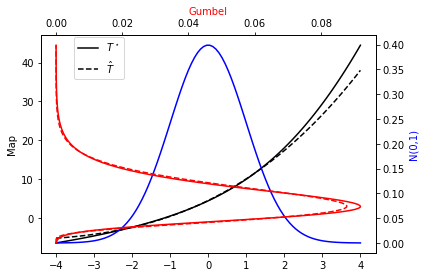

In [13]:
plot_mapping(pi, Tstar, push_rho, T)

## Integrated exponential parametrization

This parameterization takes the form:

$$ T_k({\bf a};{\bf x}) = c({\bf a}_c;{\bf x}) + \int_0^{x_k} \exp\left( h({\bf a}_e;x_1,\ldots,x_{k-1},t) \right) dt \;,$$

where $c$ and $h$ are themselves two parametric approximations. We use polynomial approximations for both of these functions, such that:

$$ c({\bf a}_c,{\bf x}) = \Phi_c({\bf x}) {\bf a}_c \quad \text{and} \quad h({\bf a}_e,{\bf x}) = \Phi_e(x_1,\ldots,x_{k-1},t) {\bf a}_e \;.$$

In general we will require the approximation $c$ to be constant in $x_d$ and this is achieved using a zero's order approximation in the $x_d$ dimension of $c$. 

A 3-rd order approximation of the transport map is then built:

In [14]:
order = 3
Tk_list = []
active_vars = []
c_basis_list = [S1D.HermiteProbabilistsPolynomial()]
c_orders_list = [0]
c_approx = FUNC.MonotonicLinearSpanApproximation(
    c_basis_list, spantype='full', order_list=c_orders_list)
e_basis_list = [S1D.ConstantExtendedHermiteProbabilistsFunction()]
e_orders_list = [order]
e_approx = FUNC.MonotonicLinearSpanApproximation(
    e_basis_list, spantype='full', order_list=e_orders_list)
Tk = FUNC.MonotonicIntegratedExponentialApproximation(c_approx, e_approx)
Tk_list.append( Tk )
active_vars.append( [0] )
T = MAPS.IntegratedExponentialTriangularTransportMap(active_vars, Tk_list)

Alternatively one could use the default constructor:

In [15]:
T = TM.Default_IsotropicIntegratedExponentialTriangularTransportMap(
    1, order, 'full')

We are then ready to set up the minimization problem

$$
\hat{T} = \arg\min_{T \in \mathcal{T}} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert \nu_\pi \right) \;.
$$

We need in particular to select $\nu_\rho$ and to construct the distribution $T_\sharp \nu_\rho$:

In [16]:
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

And we are ready to **solve** the KL-divergence minimization problem:

In [17]:
qtype = 3      # Gauss quadrature
qparams = [20] # Quadrature order
reg = None     # No regularization
tol = 1e-10    # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   Function value:          1.429205
2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000000
2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        13
2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     15
2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     27
2018-12-08 18:52:58 INFO: TM.CommonBasisIntegratedExponentialTriangularTransportMap: minimize_kl_divergence:   N. Hessian evaluations: 

Let's check the PDF approximation against the exact Gumbel distribution and the corresponding maps...

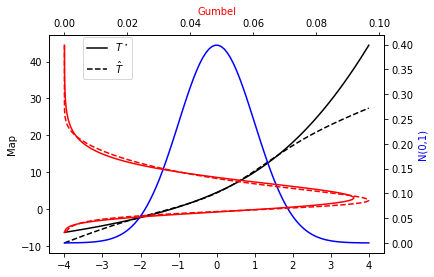

In [18]:
plot_mapping(pi, Tstar, push_rho, T)

## Integrated squared parametrization

This parameterization takes the form:

$$ T_k({\bf a};{\bf x}) = c({\bf a}_c;{\bf x}) + \int_0^{x_k} \left( h\left({\bf a}_e;x_1,\ldots,x_{k-1},t \right) \right)^2 \, dt \;,$$

where $c$ and $h$ are themselves two parametric approximations. We use polynomial approximations for both of these functions, such that:

$$ c({\bf a}_c,{\bf x}) = \Phi_c({\bf x}) {\bf a}_c \quad \text{and} \quad h({\bf a}_e,{\bf x}) = \Phi_e(x_1,\ldots,x_{k-1},t) {\bf a}_e \;.$$

The advantage of using this parametrization, with Hermite polynomials for $c({\bf a}_c,{\bf x})$ and constant extended Hermite functions (see ``SpectralToolbox`` documentation) for $h({\bf a}_e,{\bf x})$, is that the integration can be performed analytically, rather than numerically.
In general we will require the approximation $c$ to be constant in $x_d$ and this is achieved using a zero's order approximation in the $x_d$ dimension of $c$.

 We construct a 3-rd order approximation with the following code:

In [19]:
order = 3
Tk_list = []
active_vars = []
c_basis_list = [S1D.HermiteProbabilistsPolynomial()]
c_orders_list = [0]
c_approx = FUNC.MonotonicLinearSpanApproximation(
    c_basis_list, spantype='full', order_list=c_orders_list)
e_basis_list = [S1D.ConstantExtendedHermiteProbabilistsFunction()]
e_orders_list = [order]
e_approx = FUNC.MonotonicLinearSpanApproximation(
    e_basis_list, spantype='full', order_list=e_orders_list)
Tk = FUNC.MonotonicIntegratedSquaredApproximation(c_approx, e_approx)
Tk_list.append( Tk )
active_vars.append( [0] )
T = MAPS.IntegratedSquaredTriangularTransportMap(active_vars, Tk_list)

Alternatively one could use the default constructor:

In [20]:
T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    1, order, 'full')

We are then ready to set up the minimization problem

$$
\hat{T} = \arg\min_{T \in \mathcal{T}} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert \nu_\pi \right) \;.
$$

We need in particular to chose $\nu_\rho$ and to construct the distribution $T_\sharp \nu_\rho$:

In [21]:
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

And we are ready to **solve** the KL-divergence minimization problem:

In [22]:
qtype = 3      # Gauss quadrature
qparams = [20] # Quadrature order
reg = None     # No regularization
tol = 1e-10    # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Function value:          1.429483
2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000000
2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Number of iterations:         8
2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:      9
2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     16
2018-12-08 18:52:59 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Hessian evaluations:       8


Let's check the PDF approximation against the exact Gumbel distribution and the corresponding maps...

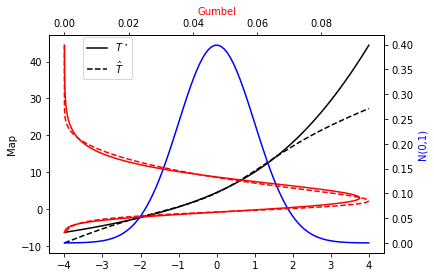

In [23]:
plot_mapping(pi, Tstar, push_rho, T)

## Sampling from the approximation
One of the strength of the transport map approach is that once the map $\hat{T}$ is constructed, sampling from $\hat{T}_\sharp \nu_\rho \approx \nu_\pi$ becomes a trivial and computationally cheap task. In fact, 

$$ \{{\bf x}_i\}_{i=1}^M \sim \rho  \qquad \Rightarrow \qquad  \{\hat{T}({\bf x}_i)\}_{i=1}^M \sim \hat{T}_\sharp \nu_\rho \approx \nu_\pi$$

This process is hidden to the user, who can directly handle the object $\hat{T}_\sharp \nu_\rho$.

### Monte-Carlo sampling

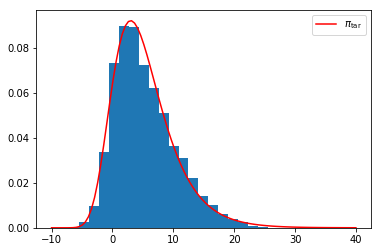

In [24]:
M = 10000
samples = push_rho.rvs(M)
plt.figure()
plt.hist(samples,bins=20,normed=True);
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.legend();

### Gauss quadratures

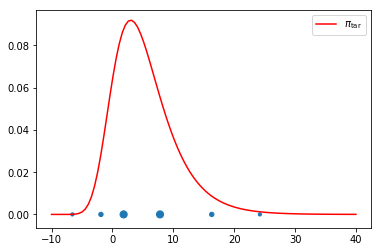

In [25]:
M = 5
(xq,wq) = push_rho.quadrature(qtype=3, qparams=[M])
plt.figure()
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.scatter(xq, np.zeros(len(xq)), s=100*wq+10.);
plt.legend();

The approximation of higher order quadrature rules require the construction of higher order approximations. Let us try to construct a 10-th order quadrature rule using a 10-th order integrated exponential approximation.

2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence: Optimization terminated successfully
2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Function value:          1.418950
2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Norm of the Jacobian:    0.000001
2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   Number of iterations:        14
2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. function evaluations:     15
2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Jacobian evaluations:     28
2018-12-08 18:53:00 INFO: TM.IntegratedSquaredTriangularTransportMap: minimize_kl_divergence:   N. Hessian evaluations:      14


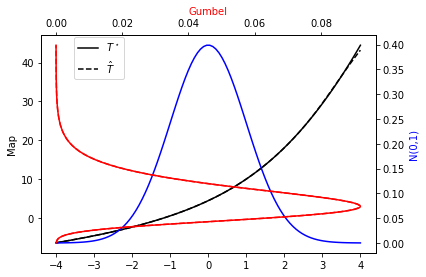

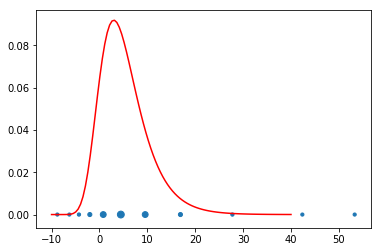

In [26]:
order = 10
T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(1, order, 'full')
rho = DIST.StandardNormalDistribution(1)
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

qtype = 3      # Gauss quadrature
qparams = [20] # Quadrature order
reg = None     # No regularization
tol = 1e-10    # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

plot_mapping(pi, Tstar, push_rho, T)

M = 10
(xq,wq) = push_rho.quadrature(qtype=3, qparams=[M])
plt.figure()
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.scatter(xq, np.zeros(len(xq)), s=100*wq+10.);

## Accuracy diagnostics

The estimation of the accuracy of the approximation $\hat{T}_\sharp \nu_\rho$ of $\nu_\pi$ is a fundamental feature deriving from the fact that we are not only computing a density approximation, but also a transport attaining this approximation.

### Variance diagnostic

As shown in [[TM1]](aa-references.html#elmoselhy2012), as $\mathcal{D}_{\rm KL}\left(T_\sharp \nu_\rho \middle\Vert \nu_\pi\right) \rightarrow 0$ (i.e. as $T\rightarrow T^\star$), the following hold:

$$ \mathcal{D}_{\rm KL}\left(T_\sharp \nu_\rho \middle\Vert \nu_\pi\right) \approx \frac{1}{2} \mathbb{V}{\rm ar}_\rho\left[ \log \frac{\rho}{T^\sharp \pi} \right] $$

This diagnostic can be easily computed using the following code:

In [27]:
import TransportMaps.Diagnostics as DIAG
pull_pi = DIST.PullBackTransportMapDistribution(T, pi)
var = DIAG.variance_approx_kl(rho, pull_pi, qtype=3, qparams=[20])
print("Variance diagnostic: %e" % var)

Variance diagnostic: 8.087302e-06


Let us then look at how this quantity behaves as we increase the order of the approximation.

In [28]:
def plot_var_diag():
    var_list = []
    ord_list = list(range(1,10))
    for order in ord_list:
        T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
            1, order, 'full')
        push_rho = DIST.PushForwardTransportMapDistribution(T, rho)
        log = push_rho.minimize_kl_divergence(
            pi, qtype=qtype, qparams=qparams,
            regularization=reg, tol=tol, ders=ders)
        pull_pi = DIST.PullBackTransportMapDistribution(T, pi)
        v = DIAG.variance_approx_kl(rho, pull_pi, qtype=3, qparams=[20])
        var_list.append(v)
    plt.figure()
    plt.semilogy(ord_list, var_list, '-o');
    plt.grid();
    plt.xlabel('Order');
    plt.ylabel('Variance diagnostic');

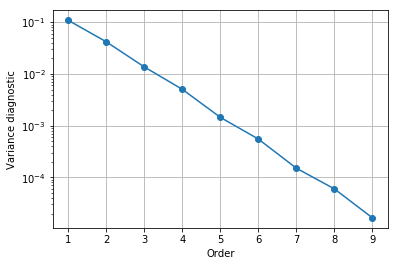

In [29]:
TM.setLogLevel(logging.WARNING)
plot_var_diag()